### (할 일)

- [ ] VRegNet
    - [x] VNet + sfcn의 classifier 작성
    - [x] VNet + sfcn의 classifier 실험
    - [ ] VNet + sfcn 작성
    - [ ] VNet + sfcn 실함
    - [ ] VNet + fc layer 작성
    - [ ] VNet + fc layer 실험

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

In [2]:
import numpy as np
import nibabel as nib
import pandas as pd
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchio as tio
from models.segmentation import *    # DiceLoss, GeneralizedDiceLoss, VNet
from models.sfcn import *
from models.pretrained_cnn import *
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import gc
import wandb

In [3]:
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Wed Mar 29 20:28:25 2023
TorchIO version: 0.18.83


In [4]:
RANDOM_SEED = 551

In [5]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print('Device:', device)
#print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Count of using GPUs: 2


### segmentation

In [7]:
def prepare_dataset(image_dir='./input_nifti_crop/', label_dir='./seg_nifti_crop/'):
        # img_list = list(map(lambda path: img_dir + path, os.listdir(img_dir)))
    filenames = os.listdir(image_dir)  # image_dir랑 label_dir에 저장되어있는 파일명이 같음

    subjects = []
    for filename in tqdm(filenames):
        subject = tio.Subject(
            img = tio.ScalarImage(image_dir + filename),
            label = tio.LabelMap(label_dir + filename))   # label => LabelMap!!!!!!!
        subjects.append(subject)
    dataset = tio.SubjectsDataset(subjects)
    return subjects, dataset

In [8]:
def run_training(net_seg):
    running_seg_loss = 0.0

    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']

#         print('before')
#         plt.imshow(labels[0,0,:,:,labels.shape[4]//2])
#         plt.show()

        
#         print('labels:', labels[0,0,:,:,labels.shape[4]//2])
        
#         l1=(labels==1)
#         l0=(labels==0)
#         labels = torch.cat((l0,l1),1)
        
#         print('after')
#         plt.imshow(labels[0,0,:,:,labels.shape[4]//2])
#         plt.show()
#         plt.imshow(labels[0,1,:,:,labels.shape[4]//2])
#         plt.show()
#         break

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)
#         if (i % effective_batchsize) == 0:
        optimizer_seg.zero_grad()
        
        net_seg.train()
        outputs_seg = net_seg(inputs)

        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
#         ##
#         print('input:',outputs_seg.shape,'target:', labels.shape)
        loss_seg = criterion_seg(outputs_seg, labels)

        loss_seg.backward()
        optimizer_seg.step()

        running_seg_loss += loss_seg.detach().cpu().item()
        gc.collect()
        torch.cuda.empty_cache()
    
    avg_loss = running_seg_loss / len(train_loader)
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    
    return avg_loss, one_output_seg, one_output_img, one_output_lbl

In [9]:
def run_validation(net_seg):
    net_seg.eval()
  
    running_seg_loss = 0.0
    total_output_seg=[]
    total_output_img=[]
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(valid_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    
            
#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)
            
            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)
            
            net_seg.eval()
            
            total_inputs=copy.deepcopy(inputs)
            total_output_img.append(total_inputs.detach().cpu().numpy())
            
            outputs_seg = net_seg(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            total_outputs=copy.deepcopy(outputs_seg)
            total_output_seg.append(total_outputs.detach().cpu().numpy())
            
            loss_seg = criterion_seg(outputs_seg, labels)
            running_seg_loss += loss_seg.detach().cpu().item()
    avg_loss = running_seg_loss / len(valid_loader)
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]

    one_output_lbl = labels.detach().cpu().numpy()[0]
    #total_output_img=np.reshape(1,224,224,32)
    #total_output_seg=np.reshape(1,224,224,32)

    return avg_loss, one_output_seg, one_output_img, one_output_lbl, total_output_seg, total_output_img

In [10]:
image_dir = './input_nifti_crop/'
label_dir = './seg_nifti_crop/'
subjects, dataset = prepare_dataset(image_dir, label_dir)

100%|██████████████████████████████████████| 115/115 [00:00<00:00, 23329.87it/s]


In [11]:
print('Dataset size : ', len(dataset), 'subjects')

Dataset size :  115 subjects


In [12]:
set_seed()

split_rate = 0.8
_, d, w, h = dataset[0].shape
img_size = 224  # [16,32,48,64,80,96,112,128,144,160]
new_d, new_w, new_h = d/img_size, w/img_size, h/img_size

# transformation
train_transform = tio.Compose([
#     tio.Resample(1.5),
    tio.Resample((new_d, new_w, new_h)),
#     tio.Crop((10,10,50,30,10,10)),
#     tio.Clamp(480,720),
    tio.ZNormalization(),
#     tio.OneHot(),
])

valid_transform = tio.Compose([
#     tio.Resample(1.5),
    tio.Resample((new_d, new_w, new_h)),
#     tio.Crop((10,10,50,30,10,10)),
#     tio.Clamp(480,720),
    tio.ZNormalization(),
#     tio.OneHot(),
])

# data split
set_seed()
num_subjects = len(dataset)
num_train_subjects = int(split_rate * num_subjects)
num_valid_subjects = num_subjects - num_train_subjects
num_split_subjects = num_train_subjects, num_valid_subjects
train_subjects, valid_subjects = random_split(subjects, num_split_subjects)

# training set
train_set = tio.SubjectsDataset(
    train_subjects, transform=train_transform)
# validation set
valid_set = tio.SubjectsDataset(
    valid_subjects, transform=valid_transform)

print('Training set:', len(train_set), 'subjects')
print('Validation set:', len(valid_set), 'subjects')

Training set: 92 subjects
Validation set: 23 subjects


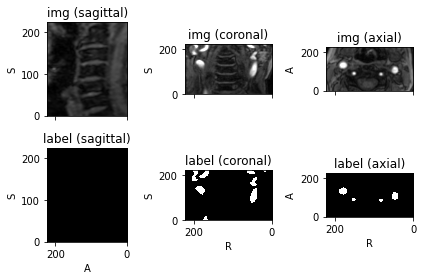

In [13]:
## 데이터셋 확인
for training_instance in train_set:
    training_instance.plot()  # SubjectDataset
    break

In [14]:
# check data size
print('shape : ',training_instance['img'].shape, training_instance['label'].shape)
# check value
shape = training_instance['label'].shape
print(training_instance['img'].data[0,shape[1]//2,:,shape[3]//2])
print(training_instance['label'].data[0,shape[1]//2,:,shape[3]//2])

shape :  (1, 224, 224, 224) (1, 224, 224, 224)
tensor([-0.6884, -0.6736, -0.5850, -0.4964, -0.4306, -0.3876, -0.3446, -0.3380,
        -0.3388, -0.3401, -0.3443, -0.3484, -0.3298, -0.2883, -0.2468, -0.1762,
        -0.0997, -0.0220,  0.0619,  0.1458,  0.2221,  0.2909,  0.3598,  0.3826,
         0.3963,  0.4054,  0.3921,  0.3788,  0.3704,  0.3669,  0.3634,  0.3840,
         0.4093,  0.4369,  0.4754,  0.5140,  0.5442,  0.5663,  0.5883,  0.5724,
         0.5490,  0.5183,  0.4514,  0.3845,  0.3032,  0.2075,  0.1117,  0.0448,
        -0.0164, -0.0766, -0.1320, -0.1874, -0.2215, -0.2344, -0.2473, -0.2536,
        -0.2587, -0.2676, -0.2956, -0.3236, -0.3795, -0.4633, -0.5471, -0.6424,
        -0.7401, -0.8325, -0.8993, -0.9661, -1.0073, -1.0230, -1.0386, -1.0255,
        -1.0067, -0.9850, -0.9494, -0.9138, -0.8791, -0.8452, -0.8113, -0.7966,
        -0.7857, -0.7842, -0.8298, -0.8753, -0.9394, -1.0220, -1.1045, -1.1034,
        -1.0856, -1.0573, -0.9770, -0.8966, -0.8364, -0.7964, -0.7564, -0

In [15]:
batch_size = 4
valid_batch_size = 4

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)
valid_loader = DataLoader(valid_set, batch_size=valid_batch_size, num_workers=16)

In [16]:
## test
normalization = 'groupnorm'
net_seg = VNet(n_channels=1, n_classes=2, n_filters=16, normalization=normalization)
net_seg

VNet(
  (block_one): ResidualConvBlock(
    (conv): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm3D()
      (2): ReLU(inplace=True)
    )
  )
  (block_one_dw): DownsamplingConvBlock(
    (conv): Sequential(
      (0): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
      (1): GroupNorm3D()
      (2): ReLU(inplace=True)
    )
  )
  (block_two): ResidualConvBlock(
    (conv): Sequential(
      (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm3D()
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm3D()
      (5): ReLU(inplace=True)
    )
  )
  (block_two_dw): DownsamplingConvBlock(
    (conv): Sequential(
      (0): Conv3d(32, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2))
      (1): GroupNorm3D()
      (2): ReLU(inplace=True)
    )
  )
  (block_three): ResidualConvBlock(
    (c

In [17]:
normalization = 'groupnorm'
num_epochs = 20
lr = 0.001
optim_class = optim.Adam

In [18]:
# Segmentation weight 생성
set_seed()
net_seg = VNet(n_channels=1, n_classes=2, n_filters=16, normalization=normalization)  # num classes: 2 (background, label)
net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
net_seg.cuda()

wandb.init(
    project='202303-segmentation',
    config={"model": "VNet", "input_size": img_size,
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "DiceLoss", "optimizer": optim_class.__name__},
    notes='Segmentation weight를 생성하기 위함'
)
wandb.watch(net_seg)

train_losses = []
validation_losses = []
# S = 8

optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
criterion_seg = DiceLoss()
# criterion_seg = GeneralizedDiceLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

set_seed()
for epoch in range(num_epochs):
    train_loss, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
    valid_loss, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
    train_img = wandb.Image(np.max(train_img_part[0].squeeze(), axis=1))
    train_truth = wandb.Image(np.max(train_input_lbl[0].squeeze(), axis=1), caption="Ground truth")
    train_pred = wandb.Image(np.max(train_seg_part[0].squeeze(), axis=1), caption="Prediction")
    valid_img = wandb.Image(np.max(valid_input_img_part[0].squeeze(), axis=1))
    valid_truth = wandb.Image(np.max(valid_input_lbl_part[0].squeeze(), axis=1), caption="Ground truth")
    valid_pred = wandb.Image(np.max(valid_output_seg_part[0].squeeze(), axis=1), caption="Prediction")
    
#     lbl_train = train_input_lbl[0, :, : ,S]
#     seg_train = train_seg_part[0, :, : , S]
#     lbl_valid = valid_input_lbl_part[0, :, : , S]
#     seg_valid = valid_output_seg_part[0, :, : , S]
    
        
#     if i%5==0:
#         print('Train')
# #         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#         plt.show()
# #         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#         plt.show()
        
#         print('Valid')
# #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#         plt.show()  
# #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#         plt.show()
        
#         # loss curve
#         plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
#         red_patch = mpatches.Patch(color='red', label='Validation')
#         blue_patch = mpatches.Patch(color='blue', label='Training')
#         plt.legend(handles=[red_patch, blue_patch])
#         plt.show()
        

    wandb.log({"train_loss": train_loss, "valid_loss": valid_loss,
               "train_img": train_img, "valid_img": valid_img,
               "train_label": train_truth, "train_pred": train_pred,
               "valid_label": valid_truth, "valid_pred": valid_pred})
wandb.finish()
torch.save(net_seg.state_dict(), 'pretrained/seg_230327_vnetencoder_{}'.format(img_size))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.94s/it]


# EPOCH 1 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.94s/it]


# EPOCH 2 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.98s/it]


# EPOCH 3 / 20


100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.01s/it]


# EPOCH 4 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.97s/it]


# EPOCH 5 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  2.00s/it]


# EPOCH 6 / 20


100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.08s/it]


# EPOCH 7 / 20


100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.01s/it]


# EPOCH 8 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.99s/it]


# EPOCH 9 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.99s/it]


# EPOCH 10 / 20


100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.02s/it]


# EPOCH 11 / 20


100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.05s/it]


# EPOCH 12 / 20


100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.03s/it]


# EPOCH 13 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.99s/it]


# EPOCH 14 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  2.00s/it]


# EPOCH 15 / 20


100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.05s/it]


# EPOCH 16 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.98s/it]


# EPOCH 17 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.98s/it]


# EPOCH 18 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.99s/it]


# EPOCH 19 / 20


100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  2.00s/it]


# EPOCH 20 / 20


---

### regression

In [7]:
def load_data(label_name, img_dir='./input_nifti_crop/', label_dir='./'):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = os.listdir(img_dir)
    subjects = []
    for filename in tqdm(filenames):
        img = nib.load(img_dir + filename).get_fdata()
        d, w, h = img.shape
        index = filename.split('.')[0]
        subject = dict(
            img = img.reshape(1, d, w, h),
            label = df[index])
        subjects.append(subject)
    return subjects

In [8]:
class NeckDataset(Dataset):
    def __init__(self, subjects, transform=None):
        self.subjects = subjects
        self.transform = transform
        self.preprocess = self._preprocess()
        
    def _preprocess(self):
        _, d, w, h = self.subjects[0]['img'].shape
        img_size = 224  # [16,32,48,64,80,96,112,128,144,160]
        new_d, new_w, new_h = d/img_size, w/img_size, h/img_size
        # transformation
        transform = tio.Compose([
            tio.Resample((new_d, new_w, new_h)),
            tio.ZNormalization(),
        ])
        return transform
        
    def __len__(self):
        return len(self.subjects)
    
    def __getitem__(self, idx):
        image = self.subjects[idx]['img']
        image = self.preprocess(image)
        label = np.array([self.subjects[idx]['label']]).astype('float16')
        if self.transform is not None:
            image = self.transform(image)
        return [image, label]

In [9]:
def train(model, train_loader, optimizer):
    total_mae, total_mse = 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.train()
    for inputs, labels in tqdm(train_loader):              
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        
        # feedforward
        outputs = model(inputs)
        
        pred = outputs.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
        # calculate loss
        mse = criterion1(outputs, labels)
        mae = criterion2(outputs, labels)
        
        # gradient initialization
        optimizer.zero_grad()
        # backpropagation
        mse.backward()
        # weight update
        optimizer.step()
        
        total_mae += mae.data.item()
        total_mse += mse.data.item()
        
        gc.collect()
        torch.cuda.empty_cache()
    return preds, truths, total_mse, total_mae

In [10]:
def valid(model, valid_loader):    
    total_mae, total_mse = 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            outputs = model(inputs)
            
            pred = outputs.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            mse = criterion1(outputs, labels)
            mae = criterion2(outputs, labels)
            
            total_mae += mae.data.item()
            total_mse += mse.data.item()
        
    return preds, truths, total_mse, total_mae

In [11]:
img_dir = './input_nifti_crop/'
label_dir = 'labels/data_975.csv'
label_name = 'FL_WMH_VOL_icv'

In [12]:
batch_size = 4
test_batch_size = 4

In [13]:
# load data
subjects = load_data(label_name, img_dir, label_dir)

# initialize seed
set_seed()

# train / test split
subjects_train, subjects_test = train_test_split(subjects, test_size=0.2)

# train set
train_set = NeckDataset(subjects_train)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

# test set & loader
test_set = NeckDataset(subjects_test)
test_loader = DataLoader(test_set, batch_size=test_batch_size, num_workers=16)

100%|█████████████████████████████████████████| 115/115 [00:03<00:00, 29.35it/s]


In [14]:
print('Dataset size : ', len(subjects), 'subjects')
print('Training set:', len(train_set), 'subjects')
print('Validation set:', len(test_set), 'subjects')

Dataset size :  115 subjects
Training set: 92 subjects
Validation set: 23 subjects


In [15]:
## 데이터셋 확인
for training_instance in train_set:
    print(training_instance[0].shape)
    print(training_instance[0])
    print(training_instance[1])
    break

(1, 224, 224, 224)
[[[[-0.3630873  -0.3597922  -0.3505659  ... -0.40394664 -0.5085114
    -0.54585594]
   [-0.37363166 -0.37109166 -0.36397973 ... -0.4043036  -0.5092528
    -0.54673463]
   [-0.43689772 -0.43888852 -0.44446275 ... -0.40644544 -0.5137012
    -0.55200684]
   ...
   [-1.5185717  -1.520082   -1.5243107  ...  0.5652407   0.39820617
     0.33855098]
   [-1.4922109  -1.4961925  -1.5073409  ...  0.6409458   0.4589185
     0.3939088 ]
   [-1.4878174  -1.4922109  -1.5045127  ...  0.65356326  0.46903723
     0.4031351 ]]

  [[-0.34962445 -0.32809836 -0.26782534 ... -0.5354901  -0.424088
    -0.38430148]
   [-0.3570835  -0.33631262 -0.278154   ... -0.534173   -0.4198422
    -0.3790097 ]
   [-0.40183818 -0.38559797 -0.3401255  ... -0.5262702  -0.39436722
    -0.34725899]
   ...
   [-1.5311933  -1.5305561  -1.5287721  ...  0.67304885  0.56442356
     0.5256288 ]
   [-1.5132467  -1.5127143  -1.5112238  ...  0.73087347  0.60431045
     0.55910933]
   [-1.5102556  -1.5097407  -1.508299

In [16]:
# # EX. VNet + fc
# class RegNet(VNet):
    
#     def __init__(self, n_channels, n_classes=2, n_filters=16, normalization='none', out_features=1, dropout_p=0., activation_fcn=True):
#         super(RegNet, self).__init__(n_channels, n_classes, n_filters, normalization)
#         self.activation_fcn = activation_fcn
#         self.classifier = nn.Sequential(
#             nn.AvgPool3d(5),  # [5,6,5]
#             nn.Dropout(p=dropout_p, inplace=False),
#             nn.Conv3d(in_channels=256, out_channels=64, kernel_size=1, stride=1)
#         )
#         self.fc = nn.Sequential()
#         self.fc.add_module('linear_1', nn.Linear(512, out_features))
        
#     def forward(self, inputs):
#         # vnet encoder
#         x1 = self.block_one(inputs)
#         x1_dw = self.block_one_dw(x1)
#         x2 = self.block_two(x1_dw)
#         x2_dw = self.block_two_dw(x2)
#         x3 = self.block_three(x2_dw)
#         x3_dw = self.block_three_dw(x3)
#         x4 = self.block_four(x3_dw)
#         x4_dw = self.block_four_dw(x4)
#         x = self.classifier(x4_dw)
#         x = x.view(x.size(0), -1)
#         out = self.fc(x)
#         if self.activation_fcn:
#             out = F.leaky_relu(out)
#         return out

In [17]:
## test
net = RegNet(n_channels=1, n_classes=2, out_features=1, dropout_p=0.5, normalization='groupnorm')
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_230327_vnetencoder_224'), strict=False)
net.state_dict()

OrderedDict([('module.block_one.conv.0.weight',
              tensor([[[[[ 0.1017, -0.0111,  0.0309],
                         [ 0.1375,  0.1738,  0.1600],
                         [ 0.0053,  0.1382, -0.0611]],
              
                        [[ 0.1799,  0.0472,  0.0175],
                         [ 0.0660, -0.0312,  0.0695],
                         [ 0.2409, -0.0116, -0.0489]],
              
                        [[-0.0228,  0.0458, -0.1821],
                         [ 0.1455,  0.0039, -0.0455],
                         [ 0.1840, -0.0164,  0.2182]]]],
              
              
              
                      [[[[-0.1169,  0.1114,  0.0274],
                         [-0.0284, -0.0730,  0.1808],
                         [ 0.0158, -0.0736,  0.0820]],
              
                        [[-0.0936, -0.0628, -0.0901],
                         [-0.0566,  0.1082, -0.1899],
                         [ 0.0792, -0.1731,  0.1520]],
              
                        [[ 0.1

In [18]:
## test
for param in net.parameters():
    param.requires_grad = False

In [19]:
## test
for i, [name, param] in enumerate(net.named_parameters()):
    print(i, name)

0 module.block_one.conv.0.weight
1 module.block_one.conv.0.bias
2 module.block_one.conv.1.weight
3 module.block_one.conv.1.bias
4 module.block_one_dw.conv.0.weight
5 module.block_one_dw.conv.0.bias
6 module.block_one_dw.conv.1.weight
7 module.block_one_dw.conv.1.bias
8 module.block_two.conv.0.weight
9 module.block_two.conv.0.bias
10 module.block_two.conv.1.weight
11 module.block_two.conv.1.bias
12 module.block_two.conv.3.weight
13 module.block_two.conv.3.bias
14 module.block_two.conv.4.weight
15 module.block_two.conv.4.bias
16 module.block_two_dw.conv.0.weight
17 module.block_two_dw.conv.0.bias
18 module.block_two_dw.conv.1.weight
19 module.block_two_dw.conv.1.bias
20 module.block_three.conv.0.weight
21 module.block_three.conv.0.bias
22 module.block_three.conv.1.weight
23 module.block_three.conv.1.bias
24 module.block_three.conv.3.weight
25 module.block_three.conv.3.bias
26 module.block_three.conv.4.weight
27 module.block_three.conv.4.bias
28 module.block_three.conv.6.weight
29 module.

In [22]:
# 바꿀 값
normalization = 'groupnorm'
num_epochs = 30
weight_decay = 0.01
lr = 0.001
optim_class = optim.Adam
dropout_rate = 0.5

# EPOCH 1 / 30


100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/it]


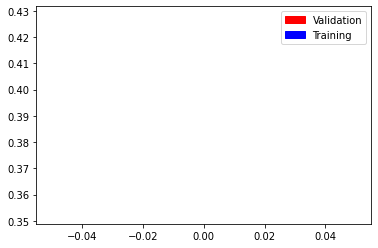

# EPOCH 2 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.03it/s]


# EPOCH 3 / 30


100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/it]


# EPOCH 4 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.03it/s]


# EPOCH 5 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.06it/s]


# EPOCH 6 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.05it/s]


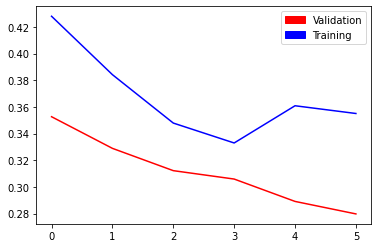

# EPOCH 7 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.05it/s]


# EPOCH 8 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


# EPOCH 9 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


# EPOCH 10 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.01it/s]


# EPOCH 11 / 30


100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.00s/it]


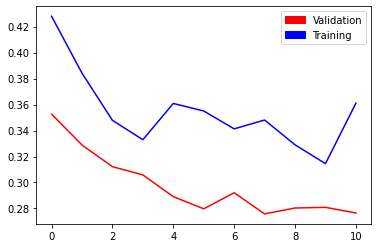

# EPOCH 12 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


# EPOCH 13 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


# EPOCH 14 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.05it/s]


# EPOCH 15 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


# EPOCH 16 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.05it/s]


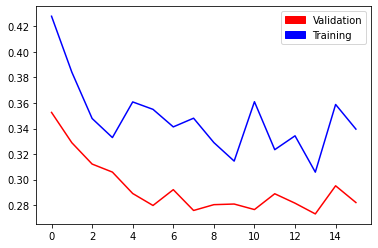

# EPOCH 17 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.07it/s]


# EPOCH 18 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.03it/s]


# EPOCH 19 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.03it/s]


# EPOCH 20 / 30


100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.03s/it]


# EPOCH 21 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.09it/s]


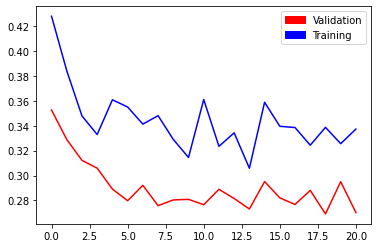

# EPOCH 22 / 30


100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.01s/it]


# EPOCH 23 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.03it/s]


# EPOCH 24 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.02it/s]


# EPOCH 25 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.01it/s]


# EPOCH 26 / 30


100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/it]


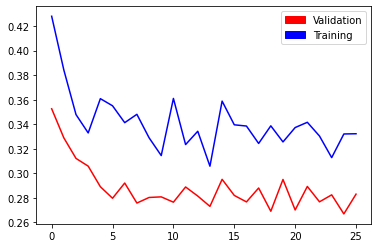

# EPOCH 27 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.00it/s]


# EPOCH 28 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.06it/s]


# EPOCH 29 / 30


100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.03s/it]


# EPOCH 30 / 30


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.02it/s]


In [23]:
set_seed()
net = RegNet(n_channels=1, n_classes=2, n_filters=16, normalization=normalization, 
             out_features=1, dropout_p=dropout_rate)  # num classes: 2 (background, label)

# parameter freeze
net.load_state_dict(torch.load('pretrained/seg_230327_vnetencoder_224'), strict=False)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.cuda()
for i, [name, param] in enumerate(net.named_parameters()):
    if i > 115:
        param.requires_grad = False

wandb.init(
    project='202303-TL',
    config={"model": "VNet+SFCN",
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "mse", "optimizer": optim_class.__name__})
wandb.watch(net)

train_losses = []
validation_losses = []

optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

set_seed()
for epoch in range(num_epochs):
    # train set
#     augment = get_augmentation_transform()
#     train_set.transform = augment
#     train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)
    
    # validation set
#     train_set.transform = None
#     valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
    
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    
    preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer)
    preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)
    
    train_losses.append(train_mse)
    validation_losses.append(valid_mse)
    if epoch%5 == 0:
        # loss curve
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()
        
    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
wandb.finish()
torch.save(net.state_dict(), 'pretrained/230329_seg+transferlearn')

In [24]:
import seaborn as sns

def predict(model, data_loader, title='', line=False):
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
    # Get correlation coefficients
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
    
    # For range setting
    _min = y_min
    _max = y_max
    
    # Figure size
#     plt.figure(figsize=(5, 5))
    
    # Reference line
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='gray', ls='--', label='Reference r = 1.0')
    
    # Regression Plot
    
    ## Scatter
    plt.scatter(truths, preds, c='steelblue', label='Pearson\'s r = {:.2f} / Spearman\'s r = {:.2f}'.format(pearson,spearman))
    
    ## Linear Regression Line
    if line:
        m, b = np.polyfit(truths, preds, 1)
        plt.plot(truths, m*truths + b, c='steelblue', label='m = {:.2f}'.format(m))
#     # Regression Plot at once
#     sns.regplot(x=truths, y=preds, ci=None, color='steelblue', label='Pearson r = {:.2f}'.format(pearson))

    if title != '':
        plt.title(title)
    
    plt.axis('square')
    plt.ylabel('Predicted WMH'); plt.xlabel('Ground Truth')
    plt.legend()
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.show()
    plt.close()
    
    return preds, truths

In [25]:
for i, (img, label) in enumerate(test_set):
    if i==0:
        y_min = label
        y_max = label
        continue
    if label > y_max:
        y_max = label
    if label < y_min:
        y_min = label

y_min, y_max

(array([0.002485], dtype=float16), array([2.482], dtype=float16))

100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.11it/s]


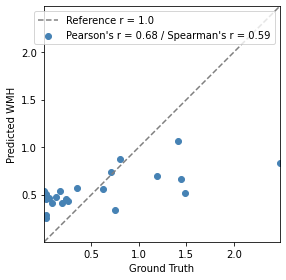

In [26]:
_, _ = predict(net, test_loader)

In [27]:
from medcam import medcam

In [28]:
from copy import deepcopy

In [29]:
gradcam_model = deepcopy(net)

In [30]:
model = medcam.inject(gradcam_model, output_dir="feature_maps_20230330", save_maps=True)

In [33]:
gradcam_loader = DataLoader(test_set, batch_size=1, num_workers=16)

In [34]:
criterion = nn.L1Loss()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(gradcam_loader):
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        print(f"[{i}]:", outputs.shape)
        print("Step [{} / {}], Loss: {:4f}\n".format(i+1, len(gradcam_loader), loss.item()))

[0]: torch.Size([1, 1])
Step [1 / 23], Loss: 0.489766

[1]: torch.Size([1, 1])
Step [2 / 23], Loss: 0.484011

[2]: torch.Size([1, 1])
Step [3 / 23], Loss: 0.413223

[3]: torch.Size([1, 1])
Step [4 / 23], Loss: 0.372958

[4]: torch.Size([1, 1])
Step [5 / 23], Loss: 1.649924

[5]: torch.Size([1, 1])
Step [6 / 23], Loss: 0.437956

[6]: torch.Size([1, 1])
Step [7 / 23], Loss: 0.536649

[7]: torch.Size([1, 1])
Step [8 / 23], Loss: 0.181541

[8]: torch.Size([1, 1])
Step [9 / 23], Loss: 0.777178

[9]: torch.Size([1, 1])
Step [10 / 23], Loss: 0.454189

[10]: torch.Size([1, 1])
Step [11 / 23], Loss: 0.266035

[11]: torch.Size([1, 1])
Step [12 / 23], Loss: 0.063826

[12]: torch.Size([1, 1])
Step [13 / 23], Loss: 0.974444

[13]: torch.Size([1, 1])
Step [14 / 23], Loss: 0.347965

[14]: torch.Size([1, 1])
Step [15 / 23], Loss: 0.319134

[15]: torch.Size([1, 1])
Step [16 / 23], Loss: 0.224924

[16]: torch.Size([1, 1])
Step [17 / 23], Loss: 0.037384

[17]: torch.Size([1, 1])
Step [18 / 23], Loss: 0.4

In [35]:
dir_name = "./feature_maps_20230330/module.classifier/"
os.listdir(dir_name)

['module.classifier']

In [36]:
os.listdir(dir_name + 'module.classifier')[:5]

['attention_map_15_0_0.nii.gz',
 'attention_map_8_0_0.nii.gz',
 'attention_map_0_0_0.nii.gz',
 'attention_map_14_0_0.nii.gz',
 'attention_map_22_0_0.nii.gz']

In [40]:
cams = [dir_name + f'module.classifier/attention_map_{i}_0_0.nii.gz' for i in range(len(gradcam_loader))]
cams

['./feature_maps_20230330/module.classifier/attention_map_0_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_1_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_2_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_3_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_4_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_5_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_6_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_7_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_8_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_9_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_10_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_11_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/attention_map_12_0_0.nii.gz',
 './feature_maps_20230330/module.classifier/atte

In [43]:
from scipy.ndimage import zoom

def show_cam(inputs, file_name):
    print(file_name)
    
    # load ground image (patient image)
    ground_img = inputs.detach().cpu().numpy().squeeze()
    print(f'ground_img.shape={ground_img.shape}')

    # get feature matrix
    heatmap = nib.load(file_name)
    heatmap = heatmap.get_fdata()
    print(f'before zoom: heatmap.shape={heatmap.shape}')

    # rescale feature matrix to ground image size
    scale1 = ground_img.shape[0] / heatmap.shape[0]
    scale2 = ground_img.shape[1] / heatmap.shape[1]
    scale3 = ground_img.shape[2] / heatmap.shape[2]
    heatmap = zoom(heatmap, zoom=(scale1, scale2, scale3))
    print(f'after zoom: heatmap.shape={heatmap.shape}')
    
    ########### 3D ###########
    # convert ndarray to tensor to get feature map image
    ground_img = torch.Tensor(ground_img.reshape(1,170,170,170))
    heatmap = torch.Tensor(heatmap)

    # dim=0: axial, 1: coronal, 2: sagittal
    gcam = torch.mul(ground_img, heatmap).sum(dim=0, keepdim=True)
    gcam = F.relu(gcam)
    print(gcam.shape)

    # gcam = F.interpolate(gcam, 170, mode="bilinear", align_corners=False)

    B,C,H,W = gcam.shape
    gcam = gcam.view(B, -1)
    gcam -= gcam.min(dim=1, keepdim=True)[0]
    gcam /= gcam.max(dim=1, keepdim=True)[0]
    gcam = gcam.view(B, C, H, W)
    print(gcam.shape)

    # convert tensor to ndarray to plot image
    gcam_img = gcam.detach().numpy().squeeze()
    ground_img = inputs.detach().cpu().numpy().squeeze()
    print(f'ground_img.shape={ground_img.shape} / gcam_img.shape={gcam_img.shape}')
    
    # axial view 3D - 노이즈성 feature가 어디서 나타는지 확인하기 위함.
    slices = 170 // 12
    for i in range(12):
        slice_idx = slices*(i+1) - 1
        print(slice_idx)
        plt.figure(figsize=(11,11))

        plt.subplot(1, 2, 1)
        plt.imshow(ground_img[slice_idx, :, :], cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(gcam_img[slice_idx, :, :], cmap='jet', alpha=1.0)
        plt.axis('off')

        plt.show()
        plt.close()

def show_mip(inputs, file_name, axis=1):
    print(file_name)
    
    # load ground image (patient image)
    ground_img = inputs.detach().cpu().numpy().squeeze()
    print(f'ground_img.shape={ground_img.shape}')

    # get feature matrix
    heatmap = nib.load(file_name)
    heatmap = heatmap.get_fdata()
    print(f'before zoom: heatmap.shape={heatmap.shape}')

    # rescale feature matrix to ground image size
    scale1 = ground_img.shape[0] / heatmap.shape[0]
    scale2 = ground_img.shape[1] / heatmap.shape[1]
    scale3 = ground_img.shape[2] / heatmap.shape[2]
    heatmap = zoom(heatmap, zoom=(scale1, scale2, scale3))
    print(f'after zoom: heatmap.shape={heatmap.shape}')
    
    ########### 2D ###########
    # convert ndarray to tensor to get feature map image
    ground_img = torch.Tensor(ground_img)
    heatmap = torch.Tensor(heatmap)

    # dim=0: axial, 1: coronal, 2: sagittal
    gcam = torch.mul(ground_img, heatmap).sum(dim=axis, keepdim=True)
    gcam = F.relu(gcam)
    print(gcam.shape)

    C,H,W = gcam.shape
    gcam = gcam.view(1, -1)
    gcam -= gcam.min(dim=1, keepdim=True)[0]
    gcam /= gcam.max(dim=1, keepdim=True)[0]
    gcam = gcam.view(C, H, W)
    print(gcam.shape)

    # convert tensor to ndarray to plot image
    gcam_img = gcam.detach().numpy().squeeze()
    ground_img = inputs.detach().cpu().numpy().squeeze()
    print(f'ground_img.shape={ground_img.shape} / gcam_img.shape={gcam_img.shape}')
    
    plt.figure(figsize=(16,16))
    plt.subplot(1, 2, 1)
    plt.imshow(np.max(ground_img, axis=axis), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(gcam_img, cmap='jet', alpha=1.0)
    plt.axis('off')

    plt.show()
    plt.close()

tensor([[1.1904]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_0_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


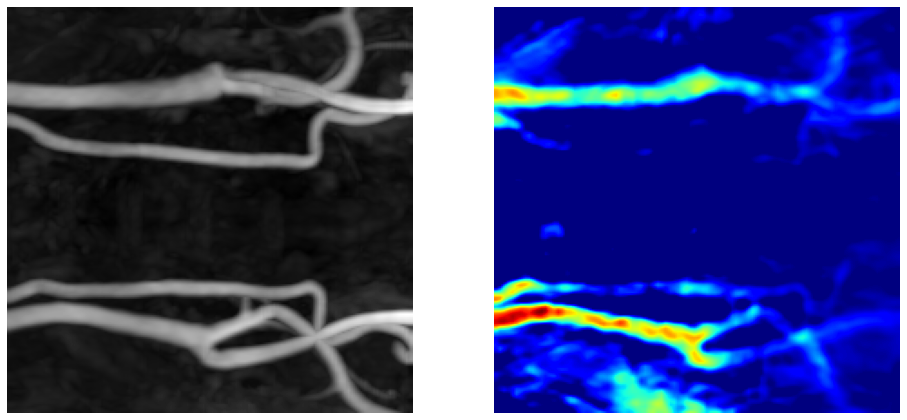

tensor([[0.0248]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_1_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


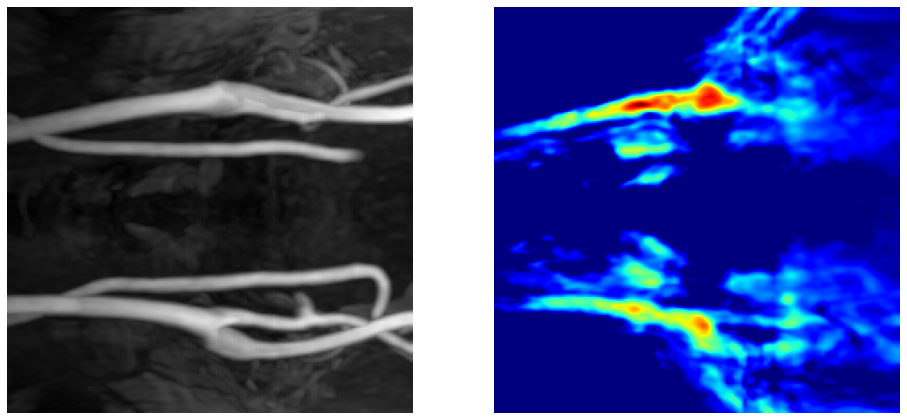

tensor([[0.7500]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_2_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


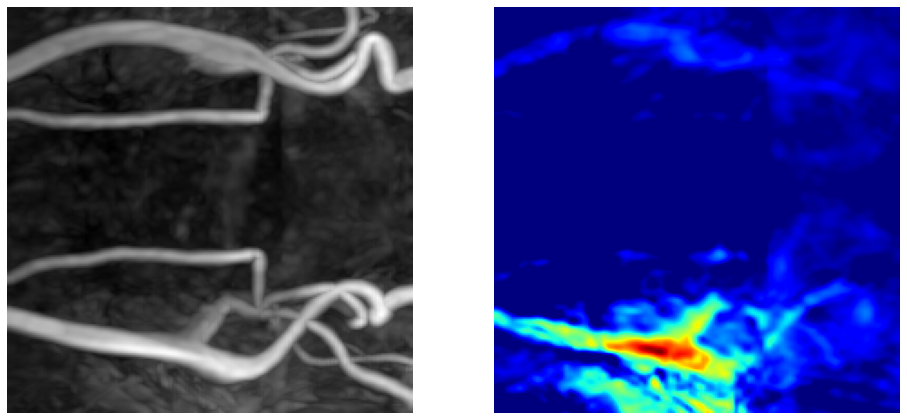

tensor([[0.1649]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_3_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


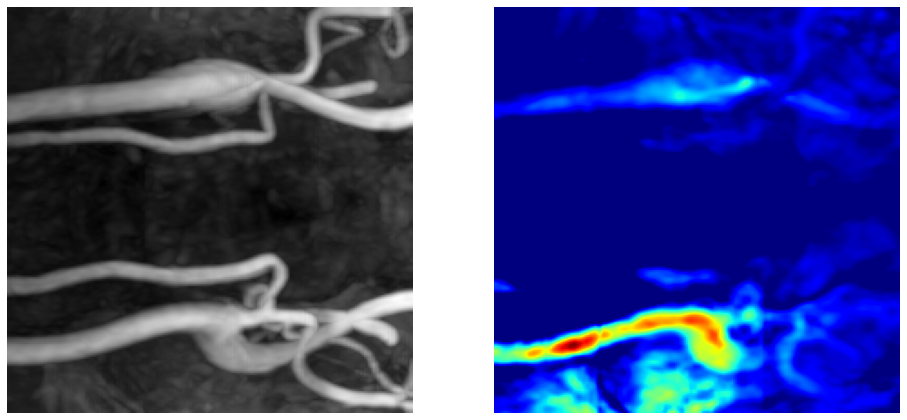

tensor([[2.4824]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_4_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


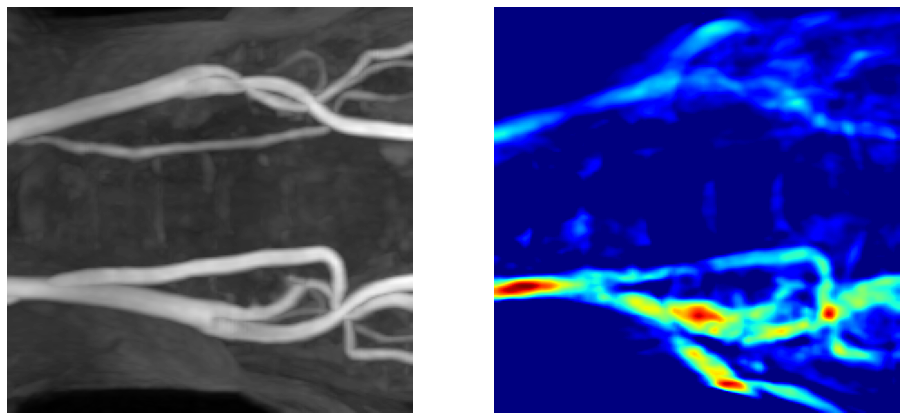

tensor([[0.0169]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_5_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


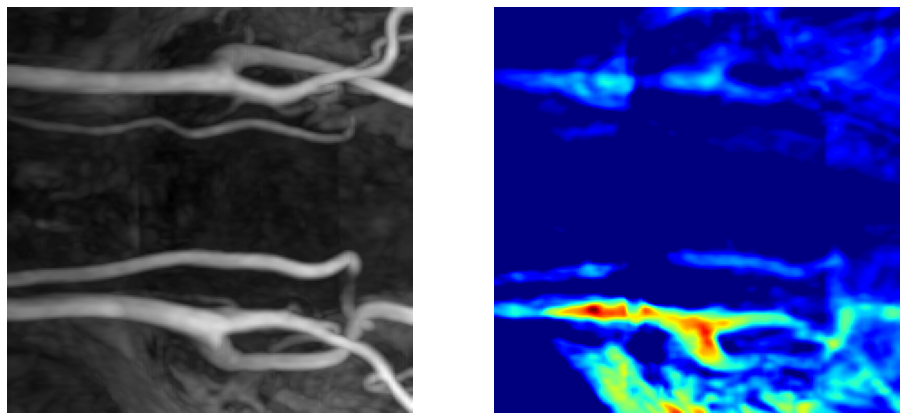

tensor([[0.0025]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_6_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


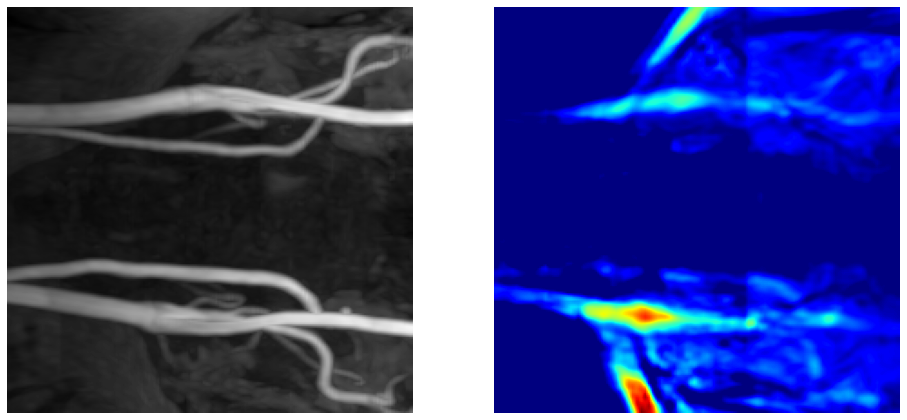

tensor([[0.2554]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_7_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


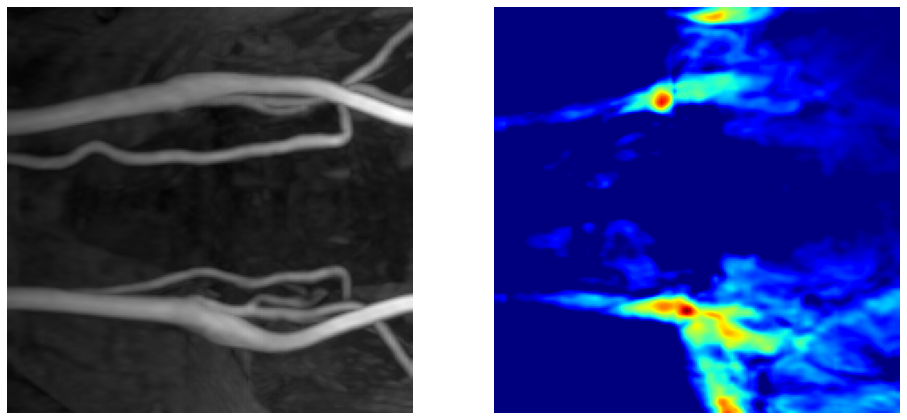

tensor([[1.4434]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_8_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


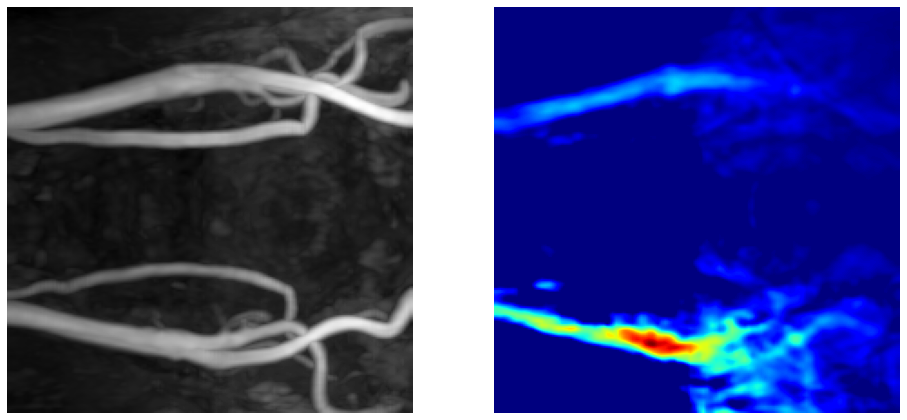

tensor([[0.0139]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_9_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


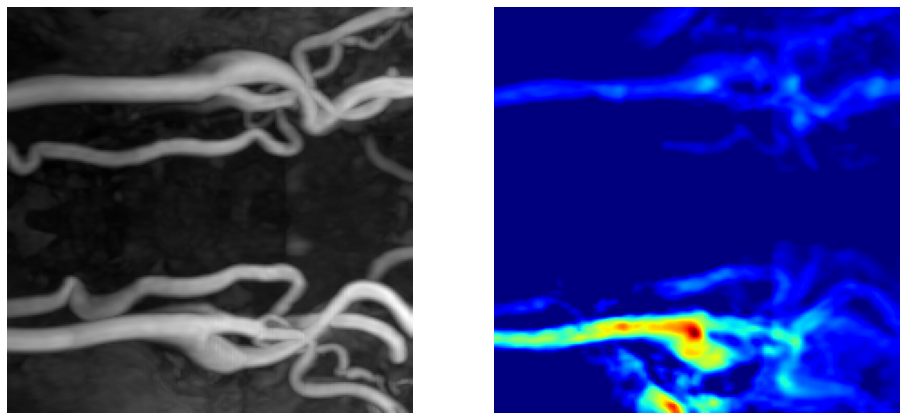

tensor([[0.0170]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_10_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


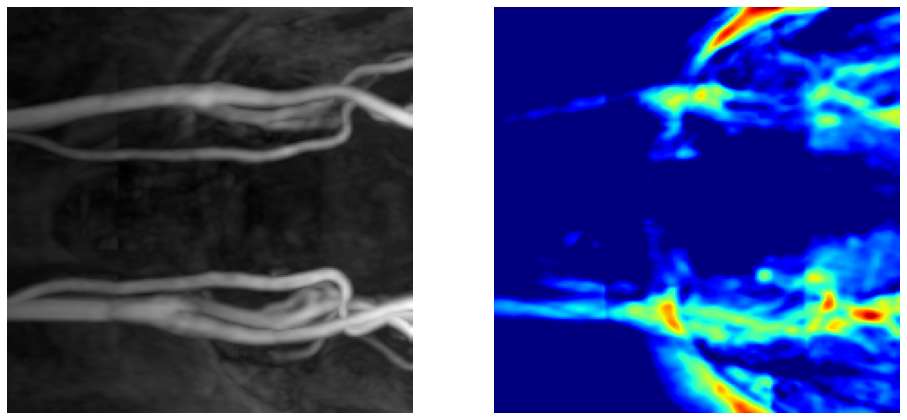

tensor([[0.6235]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_11_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


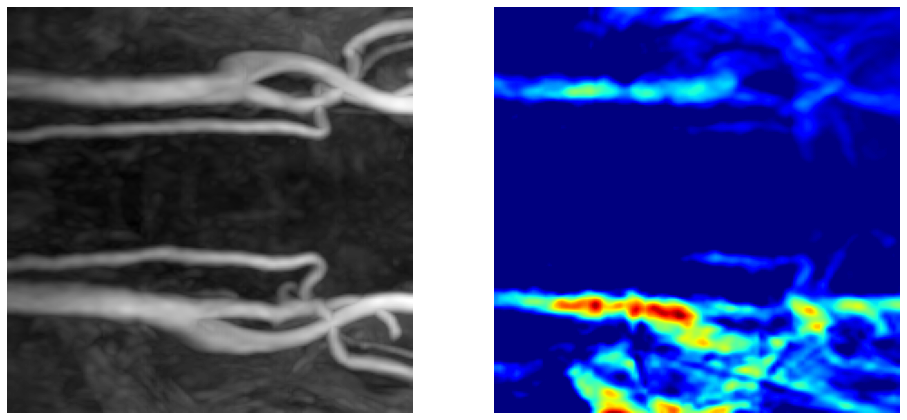

tensor([[1.4883]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_12_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


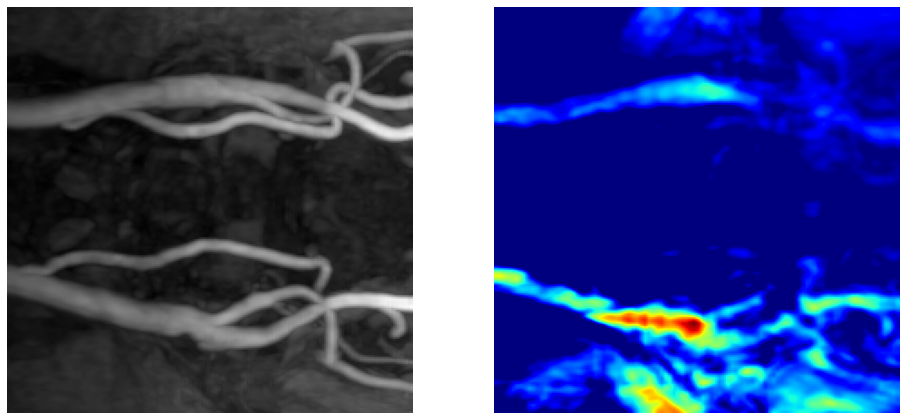

tensor([[0.1274]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_13_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


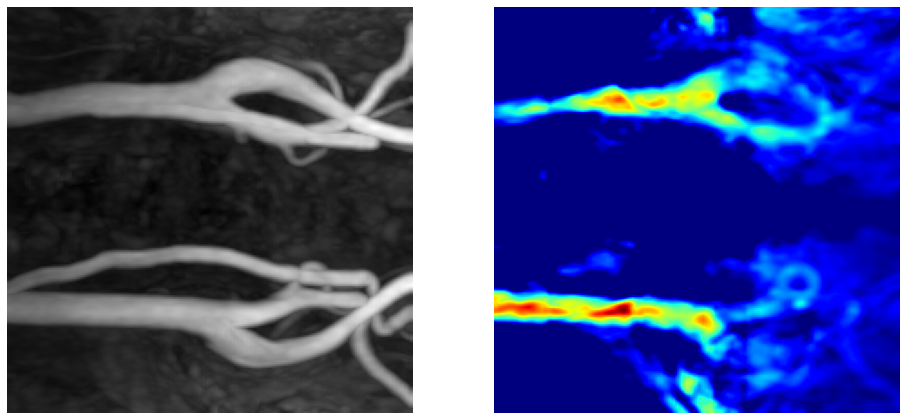

tensor([[0.0894]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_14_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


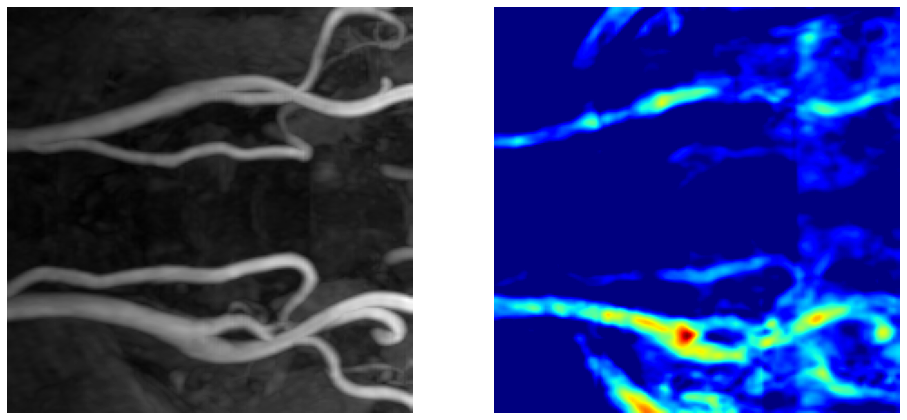

tensor([[0.3464]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_15_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


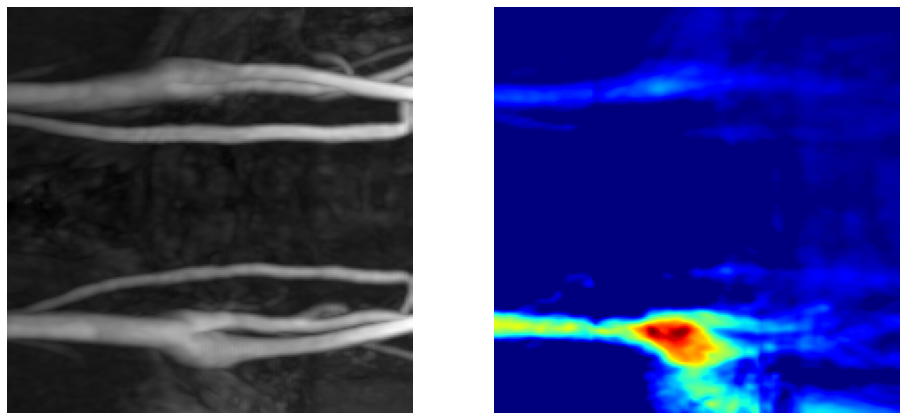

tensor([[0.7031]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_16_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


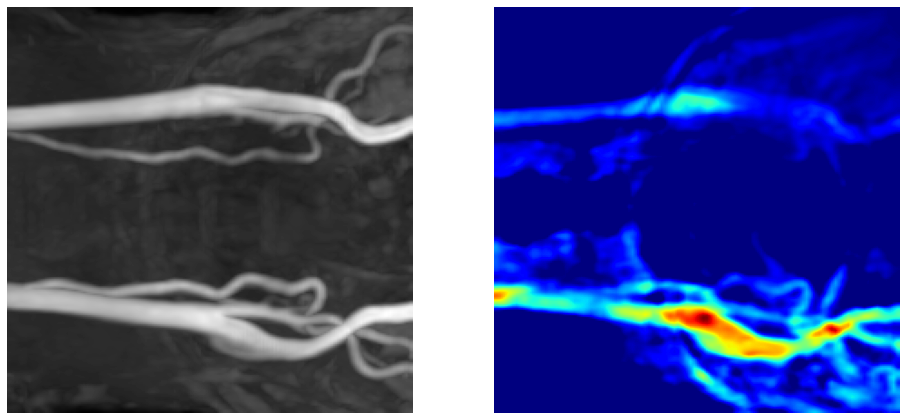

tensor([[0.0552]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_17_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


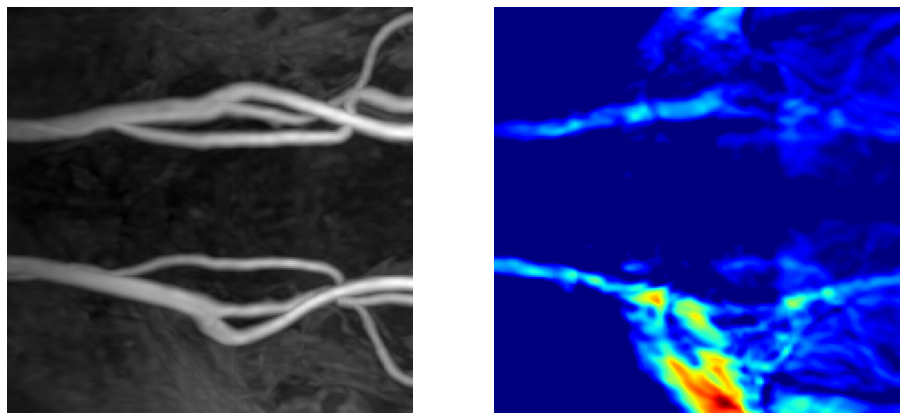

tensor([[0.0228]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_18_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


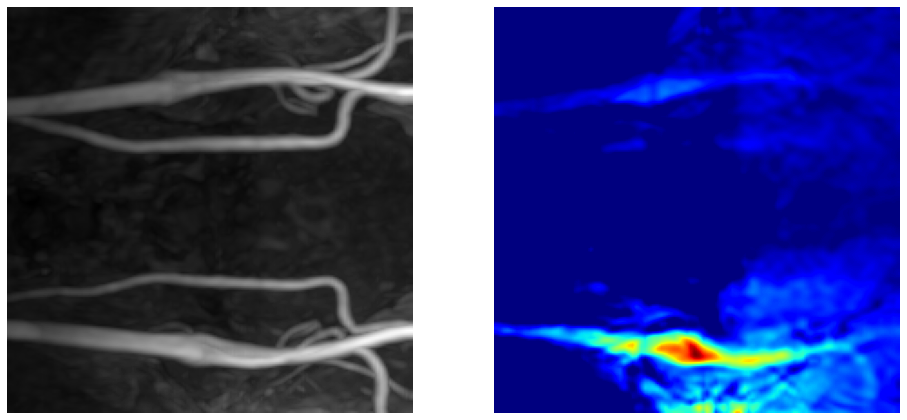

tensor([[0.8057]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_19_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


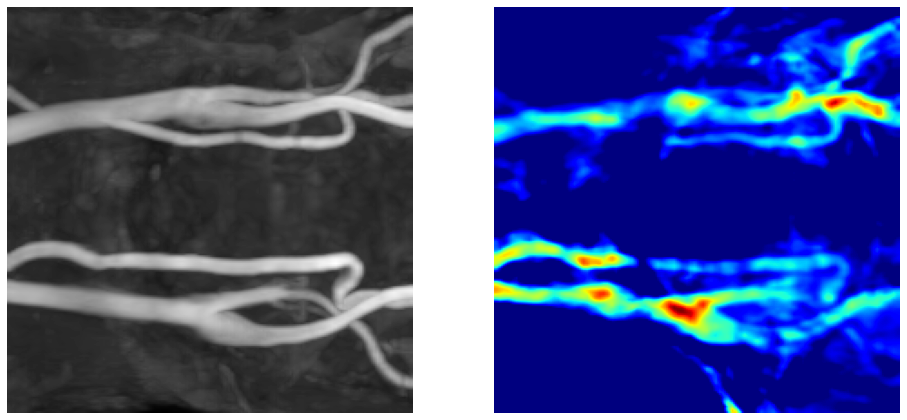

tensor([[1.4131]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_20_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


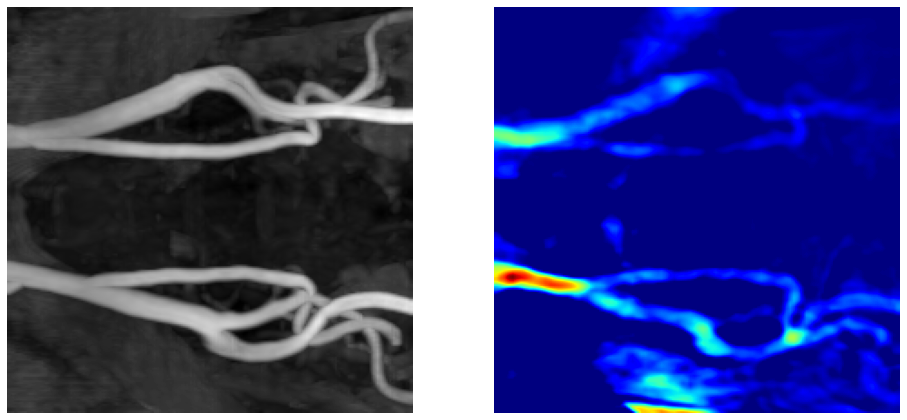

tensor([[0.2334]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_21_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


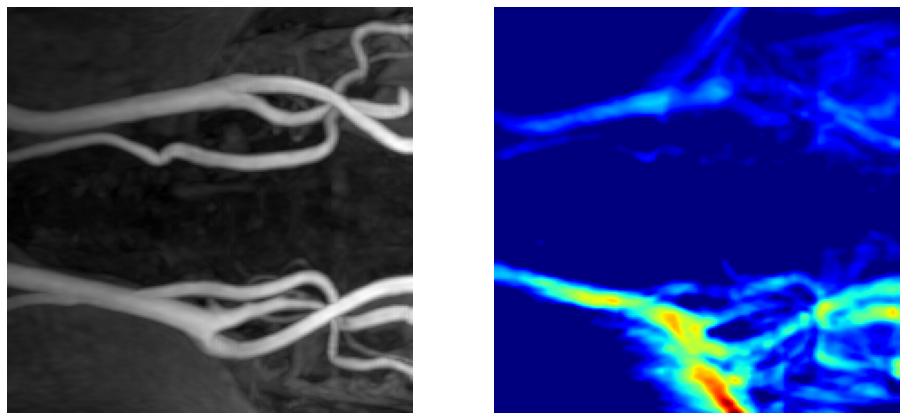

tensor([[0.1951]], dtype=torch.float16), ./feature_maps_20230330/module.classifier/attention_map_22_0_0.nii.gz
ground_img.shape=(224, 224, 224)
before zoom: heatmap.shape=(2, 2, 2)
after zoom: heatmap.shape=(224, 224, 224)
torch.Size([224, 1, 224])
torch.Size([224, 1, 224])
ground_img.shape=(224, 224, 224) / gcam_img.shape=(224, 224)


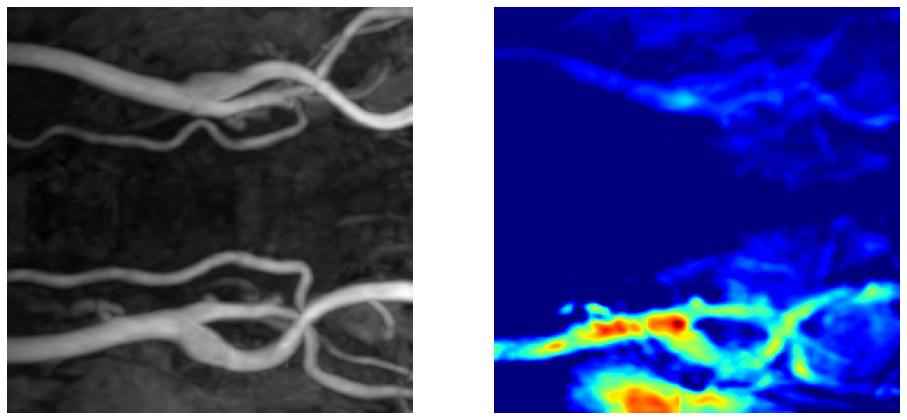

In [44]:
for i, (inputs, labels) in enumerate(gradcam_loader):
    print(labels, end=', ')
    show_mip(inputs, cams[i])